In [108]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gp
import mapclassify
import folium
from shapely.geometry import point
from util import transpose_create_geoid, plotting, food_desert_map
import sys
sys.argv.append(["--max-memory", "6G"])
import datetime
from r5py import TransportNetwork, TravelTimeMatrixComputer, TransitMode, LegMode

In [2]:
##Red Line map

#red line KML map downloaded from https://www.google.com/maps/d/u/0/viewer?mid=1-nQTrR-62ggDsL5BaeBK20_X8wA&hl=en_US&ll=0%2C0&z=12
#red line KML map converted to shapfile using https://mygeodata.cloud/converter/kml-to-shp

#create geodataframes of stations and alignment of proposed red line
stations = gp.read_file('Stations-point.shp')
alignment = gp.read_file('Alignment-line.shp')

In [4]:
##Tract geodataframe

#2021 Maryland census tract shapefile downloaded from: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2021&layergroup=Census+Tracts

#create geodataframe from 2021 census tract shapefile, narrow down to Baltimore City
tract21 = gp.read_file('tl_2021_24_tract.shp')
tract21 = tract21.loc[tract21["COUNTYFP"] == "510"]
tract21['GEOID'] = tract21['GEOID'].astype('Int64')

Text(0.5, 1.0, 'Baltimore Grocery Stores')

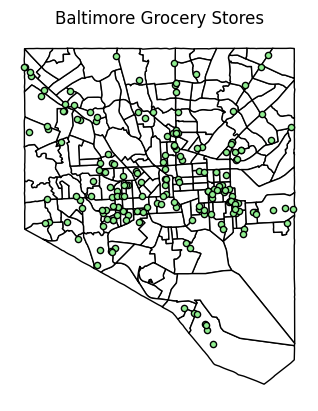

In [5]:
##Baltimore grocery store data

#download data from: https://auth.data-axle.com/signups/new?client_id=aa896f8ee71ef28c99a9b997&information_uri=https%3A%2F%2Fplatform.data-axle.com%2Fsignup_information
#Primary NAICS code for grocery stores (excluding convenience) is 445110, filtered by city and 'In Business' status

#create dataframe using DataAxle data for Baltimore (note: file was renamed for readability), narrow down to Baltimore's City's county id code
food_retailers = pd.read_csv('BaltimoreFoodRetail.csv.gz')
food_retailers = food_retailers[food_retailers["fips_code"] == 24510]
food_map = gp.GeoDataFrame(
    food_retailers, geometry=gp.points_from_xy(food_retailers.longitude, food_retailers.latitude), crs="EPSG:4326"
)
food_map['id'] = food_map.index

#plot grocery store location on Baltimore City block group map
base = tract21.plot(color='white', edgecolor='black')
food_map.plot(ax=base, marker='o', facecolor='lightgreen', markersize=20, edgecolor = 'black')
base.set_axis_off()
plt.title('Baltimore Grocery Stores')

<Axes: title={'center': 'Households without Vehicles (Percent)'}>

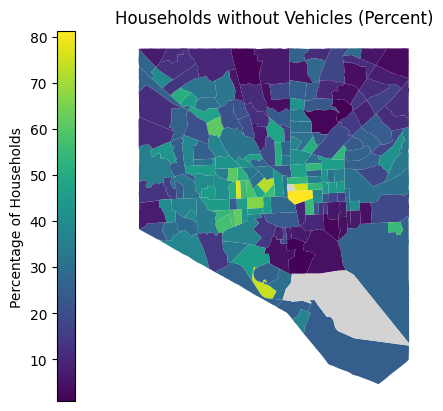

In [6]:
##Vehicles available by household

#data downloaded from: https://data.census.gov/table?q=Transportation&g=050XX00US24510$1400000&tid=ACSDT5Y2021.B08141&moe=false
#"B08203", 2021: ACS 5-Year Estimates Detailed Tables

#read cvs file, transpose, and format
vehicle_household = pd.read_csv('ACSDT5Y2021.B08203-2023-08-07T214015.csv', thousands = ',')
vehicle_household = transpose_create_geoid(vehicle_household)
vehicle_household['Total Households'] = vehicle_household['Total:'].astype(float)
vehicle_household['No Vehicle'] = vehicle_household['    No vehicle available'].astype(float)

#calculate percentage of households without a vehicle
vehicle_household['Percent No Vehicle'] = vehicle_household['No Vehicle']/vehicle_household['Total Households']*100

#restrict number of columns to avoid repeating column names
vehicle_household = vehicle_household[['Percent No Vehicle','No Vehicle','GEOID']]

#merge with geodataframe
vehicle_household_map = tract21.merge(vehicle_household, on='GEOID')

#plot map of percentage of households without a vehicle by tract
plotting(vehicle_household_map, 'Percent No Vehicle', 'Percentage of Households', 'Households without Vehicles (Percent)')

<Axes: title={'center': 'Median Household Income'}>

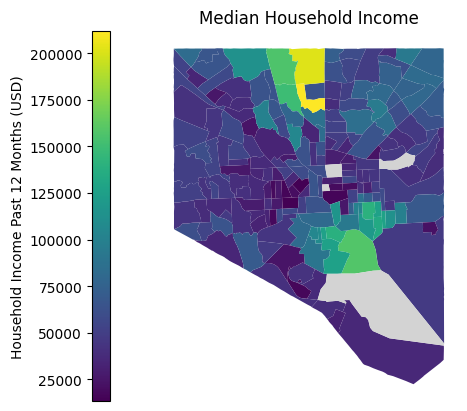

In [39]:
##Median household income

#data downloaded from: https://data.census.gov/table?q=B19013&g=050XX00US24510$1400000&tid=ACSDT5Y2021.B19013&moe=false
#"B19013", 2021: ACS 5-Year Estimates Detailed Tables
#Baltimore median houshold income from: https://data.census.gov/table?g=060XX00US2451090000&tid=ACSST5Y2021.S1901&moe=false

#read cvs file, transpose, format, and merge with geodataframe
median_house_income = pd.read_csv('ACSDT5Y2021.B19013-2023-08-12T151751.csv', thousands = ',')
median_house_income = transpose_create_geoid(median_house_income)
median_house_income['Median Household Income'] = median_house_income['Median household income in the past 12 months (in 2021 inflation-adjusted dollars)'].astype(float)
median_house_income_map = tract21.merge(median_house_income, on='GEOID')

#calculate 80% of Baltimore's median household income
baltimore_median80 = 54124*.8

#plot median household income by tract
plotting(median_house_income_map, 'Median Household Income', 'Household Income Past 12 Months (USD)', 'Median Household Income')

<Axes: title={'center': 'Population Living Below Poverty (Percent)'}>

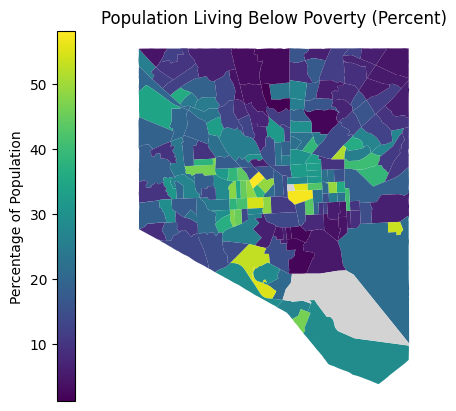

In [8]:
##Income below poverty

#data downloaded from: https://data.census.gov/table?t=Income+and+Poverty&g=050XX00US24510$1400000&tid=ACSDT5Y2021.B17101&moe=false
#"B17101", 2021: ACS 5-Year Estimates Detailed Tables

#create data frame with 2021 ACS poverty data and transpose
poverty_level = pd.read_csv('ACSDT5Y2021.B17101-2023-08-09T202711.csv', thousands = ',')
poverty_level = transpose_create_geoid(poverty_level)
poverty_level['Total Population'] = poverty_level['Total:'].astype(float)
poverty_level['Income Below Poverty'] = poverty_level['    Income in the past 12 months below poverty level'].astype(float)

#calculate the percentage of the total population with income below poverty
poverty_level['Percent Poverty'] = poverty_level['Income Below Poverty']/poverty_level['Total Population']*100

#merge with census tract geodataframe
poverty_level_map = tract21.merge(poverty_level, on='GEOID')

#plot percentage of population with income below poverty level in past 12 months by tract
plotting(poverty_level_map, 'Percent Poverty', 'Percentage of Population', 'Population Living Below Poverty (Percent)')

<Axes: title={'center': 'Population Living Below Double Poverty (Percent)'}>

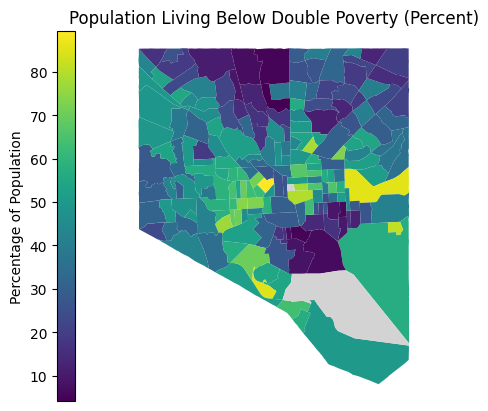

In [9]:
##Income below double/200% of the poverty level

#data downloaded from: https://data.census.gov/table?t=Income+and+Poverty&g=050XX00US24510$1400000&tid=ACSST5Y2021.S1701&moe=false
#"S1701", 2021: ACS 5-Year Estimates Detailed Tables

#create data frame with 2021 ACS double poverty data and transpose
double_poverty = pd.read_csv('ACSST5Y2021.S1701-2023-08-14T134107.csv')
double_poverty = transpose_create_geoid(double_poverty)

double_poverty = double_poverty.loc[double_poverty['        200 percent of poverty level'] != '(X)']
double_poverty['Population'] = double_poverty['Population for whom poverty status is determined'].str.replace(',','').astype(float)
double_poverty['Double Poverty'] = double_poverty['        200 percent of poverty level'].str.replace(',','').astype(float)

#calculate the percentage of the population with income below double the poverty level
double_poverty['Percent Double Poverty'] = double_poverty['Double Poverty']/double_poverty['Population']*100

#restrict number of columns to avoid repeating column names
double_poverty = double_poverty[['Double Poverty','Percent Double Poverty','GEOID']]

#merge with census tract geodataframe
double_poverty_map = tract21.merge(double_poverty, on='GEOID')

#plot percentage of population with income below double the poverty level by tract
plotting(double_poverty_map, 'Percent Double Poverty', 'Percentage of Population', 'Population Living Below Double Poverty (Percent)')


,Median Household Income,Percent Poverty,Percent Double Poverty,Percent No Vehicle
count,195.000000,197.000000,197.000000,197.000000
mean,58682.620513,21.312794,40.332083,29.054439
std,32760.101513,13.805016,18.999059,17.584442
min,13456.000000,1.173881,4.181952,0.919842
25%,38197.500000,10.946924,26.063100,13.663845
50%,50509.000000,18.511797,41.176471,26.923077
75%,67493.000000,28.930818,53.728620,41.320914
max,211667.000000,58.064516,89.288635,81.162540


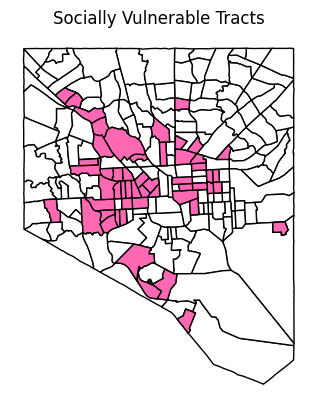

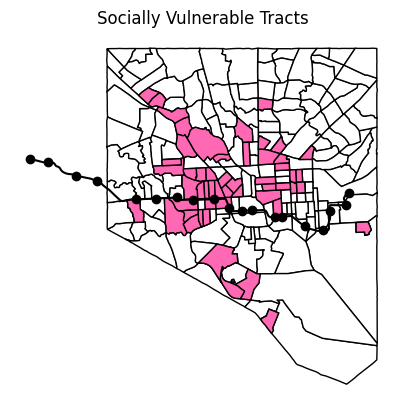

In [48]:
##Social vulnerability map

#merge dataframes and identify socially vulnerable tracts
social_vulnerability = vehicle_household_map.merge(median_house_income, on = 'GEOID').merge(poverty_level, on = 'GEOID').merge(double_poverty, on = 'GEOID')
total_data = social_vulnerability[['Median Household Income', 'Percent Poverty', 'Percent Double Poverty', 'Percent No Vehicle']].describe()
social_vulnerability = social_vulnerability.loc[(social_vulnerability['Percent Poverty'] > 20) & (social_vulnerability['Median Household Income'] < baltimore_median80) & (social_vulnerability['Percent No Vehicle'] > 30) & (social_vulnerability['Percent Double Poverty'] >40)]

#plot socially vulnerable tracts
base = tract21.plot(color = 'white', edgecolor = 'black')
social_vulnerability.plot(ax=base, color = 'hotpink', edgecolor = 'black')
plt.title('Socially Vulnerable Tracts')
base.set_axis_off()

#plot socially vulnerable tracts and red line
base = tract21.plot(color = 'white', edgecolor = 'black')
social_vulnerability.plot(ax=base, color = 'hotpink', edgecolor = 'black')
alignment.plot(ax = base, color = 'black')
stations.plot(ax = base, color = 'black')
plt.title('Socially Vulnerable Tracts')
base.set_axis_off()

total_data

In [11]:
##Blockgroup geodataframe and centroids

#shapefile downloaded from: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2021&layergroup=Block+Groups

#create block group geodataframe from 2021 Maryland block group shapefile, narrow down to Baltimore City
blockgroup21 = gp.read_file('cb_2021_24_bg_500k.shp')
blockgroup21 = blockgroup21.loc[blockgroup21["COUNTYFP"] == "510"]
blockgroup21['GEOID'] = blockgroup21['GEOID'].astype('Int64')

#find centroids of block groups
blockgroup_centroids = blockgroup21.to_crs(6487) 
blockgroup_centroids['geometry'] = blockgroup_centroids['geometry'].centroid
blockgroup_centroids = blockgroup_centroids.to_crs(4326) 
blockgroup_centroids = blockgroup_centroids.reset_index()
blockgroup_centroids['id'] = blockgroup_centroids.index

In [12]:
##Transport network (following cells use transport network for travel time matrix)

#create transport network using GTFS data (check util.py for download)
osm_fp = "maryland-latest.osm.pbf"
transport_network = TransportNetwork(
    osm_fp,
    [
        "GTFS\mdotmta_gtfs_commuter-bus.zip", 
        "GTFS\mdotmta_gtfs_light-rail.zip",
        "GTFS\mdotmta_gtfs_local-bus.zip",
        "GTFS\mdotmta_gtfs_marc.zip",
        "GTFS\mdotmta_gtfs_metro.zip"
    ]
)

In [36]:
#create travel time matrix for public transport (from each block group centroid to each grocery store)
travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins= blockgroup_centroids,
    destinations= food_map,
    departure=datetime.datetime(2023,7,20,17,00),
    transport_modes=[TransitMode.TRANSIT, LegMode.WALK],
)
ttm_public_transport = travel_time_matrix_computer.compute_travel_times()

c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:395: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLon = origin.x
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:395: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

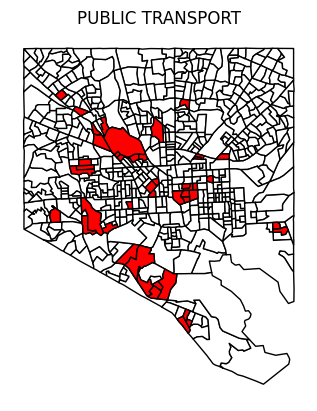

In [50]:
#plot socially vulnerable tracts where the closest grocery store is farther than 10 minutes away by public transport
public_transport_map, public_transport = food_desert_map(ttm_public_transport, 'PUBLIC TRANSPORT', blockgroup_centroids, blockgroup21, social_vulnerability)

In [15]:
#create travel time matrix for walking (from each block group centroid to each grocery store)
tc_walk = TravelTimeMatrixComputer(
    transport_network,
    origins = blockgroup_centroids,
    destinations = food_map,
    transport_modes=[LegMode.WALK],
)
ttm_walk = tc_walk.compute_travel_times()

c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:395: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLon = origin.x
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

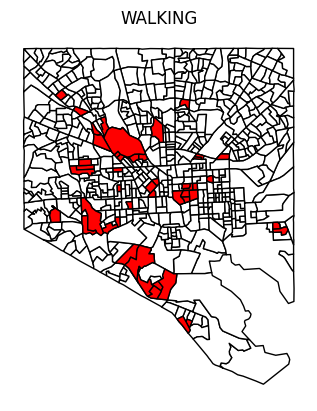

In [51]:
#plot socially vulnerable tracts where the closest grocery store is farther than 10 minutes away by foot
walking_map, walking = food_desert_map(ttm_walk, 'WALKING', blockgroup_centroids, blockgroup21, social_vulnerability)

In [17]:
#create travel time matrix for biking (from each block group centroid to each grocery store)
tc_bike = TravelTimeMatrixComputer(
    transport_network,
    origins = blockgroup_centroids,
    destinations = food_map,
    speed_cycling=16,
    transport_modes=[LegMode.BICYCLE],
)
ttm_bike = tc_bike.compute_travel_times()

c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:395: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLon = origin.x
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:395: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

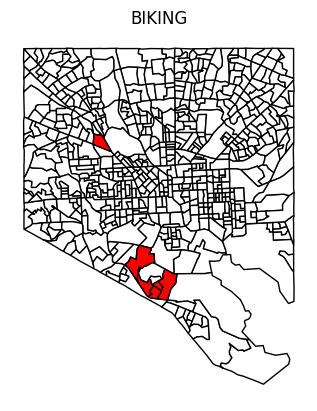

In [49]:
#plot socially vulnerable tracts where the closest grocery store is farther than 10 minutes away by bike
biking_map, biking = food_desert_map(ttm_bike, 'BIKING', blockgroup_centroids, blockgroup21, social_vulnerability)

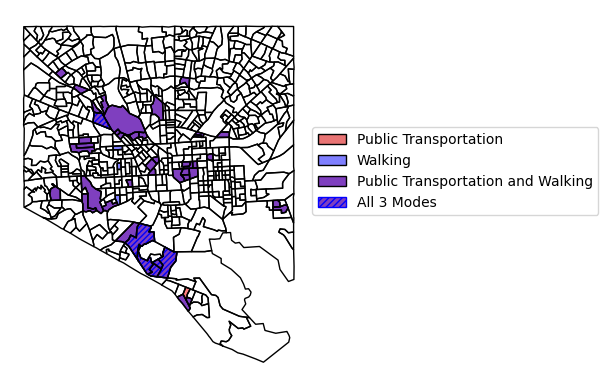

In [149]:
custom_legend = [
    Patch(facecolor='#e97474', edgecolor='black', label='Public Transportation'),
    Patch(facecolor='#7f7fff', edgecolor='black', label='Walking'),
    Patch(facecolor='#7f3fbf', edgecolor='black', label='Public Transportation and Walking'),
    Patch(facecolor='#7f3fbf', edgecolor='blue', hatch = '/////', label='All 3 Modes')
]

base = blockgroup21.plot(color = 'none', edgecolor = 'black', zorder = 4)
public_transport.plot(color = 'red', alpha = 0.5, ax = base, edgecolor = 'black')
walking.plot(color = 'blue', alpha = 0.5, ax = base, edgecolor = 'black')
biking.plot(color = 'none', hatch = '//////', ax = base, edgecolor = 'blue')
base.set_axis_off()
base.legend(handles = custom_legend, bbox_to_anchor=(2, 0.7))

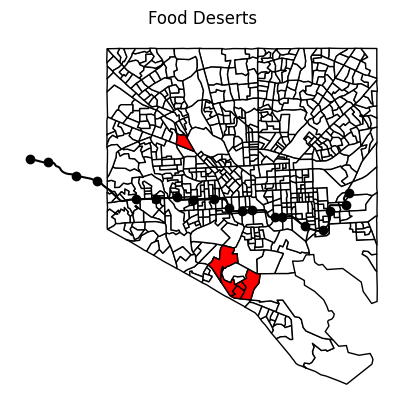

In [47]:
#plot red line and blockgroups which are food deserts by all three modes of transportation
composite = biking.merge(walking, on = 'geometry_x').merge(public_transport, on = 'geometry_x')
base = blockgroup21.plot(color = 'white', edgecolor = 'black')
composite.plot(color = 'red', ax = base, edgecolor = 'black')
alignment.plot(ax = base, color = 'black')
stations.plot(ax = base, color = 'black')
plt.title('Food Deserts')
base.set_axis_off()

Text(0.5, 1.0, 'Transit Deserts & Proposed Red Line')

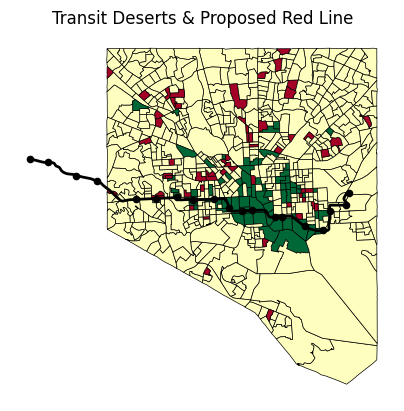

In [60]:
##Transit Desert Index

#2018 Maryland block group shapefile downloaded from: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2018.html#list-tab-790442341
#original Transit Desert Index map: http://www.transitdeserts.info/
#data obtained by contacting research team, uploaded as TD_V1_BAL_cbg.xlsx

#create data frame with transit desert index data, add missing data, prepare dataframe for merge
transit_desert = pd.read_excel('TD_V1_BAL_cbg.xlsx')
transit_desert['GEOID'] = transit_desert['GEOID10'].apply(np.int64)
transit_desert.loc[transit_desert['GEOID'] == 245101307003, 'Gap_Zscore TD'] = -0.002674515
transit_desert.loc[transit_desert['GEOID'] == 245101304001, 'Gap_Zscore TD'] = 0.038632496
transit_desert.loc[transit_desert['GEOID'] == 245100401001, 'Gap_Zscore TD'] = 3.7691295

#create geodataframe from 2018 block group shapefile, narrow down to Baltimore City, merge
blocks_map2018 = gp.read_file('tl_2018_24_bg.shp')
blocks_map2018 = blocks_map2018.loc[blocks_map2018['COUNTYFP'] == '510']
blocks_map2018['GEOID'] = blocks_map2018['GEOID'].apply(np.int64)
TDI_map = blocks_map2018.merge(transit_desert, on = 'GEOID')

#plot map of transit desert index and proposed red line
base = TDI_map.plot(column='Gap_Zscore TD', cmap= 'RdYlGn', scheme='user_defined', classification_kwds={'bins':[-1, 1]}, edgecolor = 'black', linewidths = 0.5)
ax = alignment.plot(ax=base, marker='o', color='black', linewidth=2)
ax = stations.plot(ax=base, marker='o', color='black', markersize=20)
ax.set_axis_off()
plt.title('Transit Deserts & Proposed Red Line')